# Investigation of Graph Density to differentiate Multi from Single Table Files

The paper identifies the missing ability of separating multi table files from single table files as potential future work. They try to separate by observing avg. empty col. width, but realize that the col widths between single tables and within tables between label regions are to similar.

The following cells ruffly describe the exploration on that problem and a more in depth analysis of density.

In [1]:
from os import listdir
from os.path import exists, join
import json

DATA_PATH = "../data"
OUTPUT_PATH = "../improved_output/output"
EXPERIMENT = "CrossValidationTraining"
DATASETS= ["Deco", "FusTe"]


refined_data = {}
for dataset in DATASETS:
    refined_file_path = join(DATA_PATH, dataset, "refined.json")
    with open(refined_file_path) as f:
        refined_data[dataset] = json.load(f)
        
annotation_data = {}
for dataset in DATASETS:
    annotations_file_path = join(DATA_PATH, dataset, "annotations_elements.json")
    with open(annotations_file_path) as f:
        annotation_data[dataset] = json.load(f)

preprocessed_annotation_data = {}
for dataset in DATASETS:
    annotations_file_path = join(DATA_PATH, dataset, "preprocessed_annotations_elements.json")
    with open(annotations_file_path) as f:
        preprocessed_annotation_data[dataset] = json.load(f)

def is_multi_key(key, dataset):
    try:
        return refined_data[dataset][key]["table_count"] > 2
    except KeyError:
        tables = [region for region in annotation_data[dataset][key]["regions"] if region["region_type"] == "Table"]
        return len(tables) > 2

def get_edge_count(key, dataset):
    return refined_data[dataset][key]["edge_count"]

def file_accuracies(experiment_path):
    """Returns the file accuracies for this experiment"""
    file_accuracies = {}
    for fold_num in range(10):
        accuracy_file_path = join(
            experiment_path,   
            f"fold_{fold_num}",
            f"fold_{fold_num}_file_accuracies.json",
        )

        if not exists(accuracy_file_path):
            # Fold was aborted
            continue
        with open(accuracy_file_path) as f:
            fold_file_accuracies = json.load(f)["fold_file_accuracies"]
            for key, accuracy in fold_file_accuracies.items():
                file_accuracies[key] = accuracy
    return file_accuracies

def has_noise(experiment_path):
    config_file_path = join(
            experiment_path,   
            "config.json",
        )
    with open(config_file_path) as f:
        noise = json.load(f)["noise"]
    return bool(noise)

def get_experiment_paths(dataset, noise, improved=False):
    exp_name = ("Improved" if improved else "") + EXPERIMENT
    d = join(OUTPUT_PATH, dataset, exp_name)
    experiments = listdir(d)
    return [join(d, exp) for exp in experiments if has_noise(join(d, exp)) == noise]

# Investigation of Graph Properties

One of the most basic data we have about a given spreadsheet is the graph it forms from label region annotations. Investigation of the edge count, label region count and density distribution between single and multi table files.

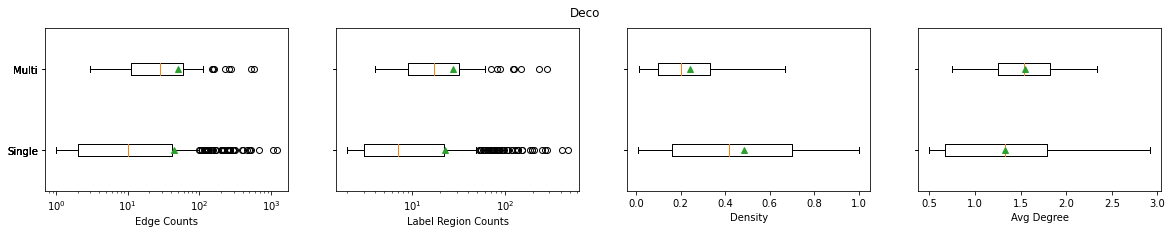

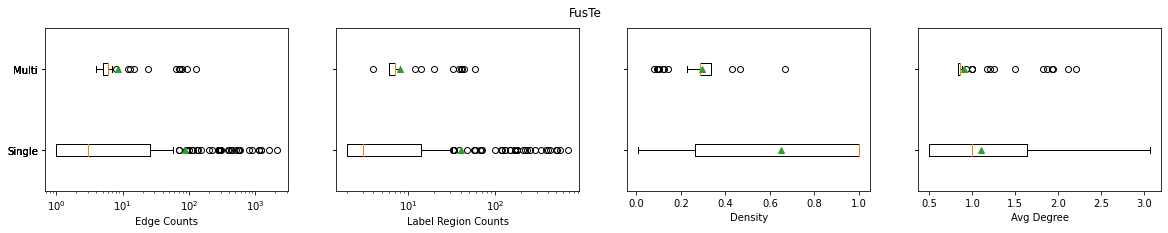

In [2]:
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (20,3)

for dataset in DATASETS:
    
    single_label_region_counts = []
    single_edge_counts = []
    single_densities = []
    single_avg_degree = []
    
    multi_label_region_counts = []
    multi_edge_counts = []
    multi_densities = []
    multi_avg_degree = []
    
    for file_key, data in refined_data[dataset].items():
        table_count = data["table_count"]
        label_region_count = data["label_region_count"]
        edge_count = data["edge_count"]

        if table_count == 1:
            single_label_region_counts.append(label_region_count)
            single_edge_counts.append(edge_count)
            single_densities.append((2 * edge_count) / (label_region_count * (label_region_count - 1)))
            single_avg_degree.append(edge_count / label_region_count)
        else:
            multi_label_region_counts.append(label_region_count)
            multi_edge_counts.append(edge_count)
            multi_densities.append((2 * edge_count) / (label_region_count * (label_region_count - 1)))
            multi_avg_degree.append(edge_count / label_region_count)
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.scatter(single_edge_counts, [1 for _ in range(len(single_edge_counts))], alpha=0.5, label="Single")
    ax1.scatter(multi_edge_counts, [2 for _ in range(len(multi_edge_counts))], alpha=0.5, label="Multi")
    ax1.set_xlabel("Edge Counts")
    ax1.legend()
    
    ax2.scatter(single_label_region_counts, [1 for _ in range(len(single_label_region_counts))], alpha=0.5, label="Single")
    ax2.scatter(multi_label_region_counts, [2 for _ in range(len(multi_label_region_counts))], alpha=0.5, label="Multi")
    ax2.set_xlabel("Label Region Counts")
    ax2.legend()
    
    ax3.scatter(single_densities, [1 for _ in range(len(single_densities))], alpha=0.5, label="Single")
    ax3.scatter(multi_densities, [2 for _ in range(len(multi_densities))], alpha=0.5, label="Multi")
    ax3.set_xlabel("Density")
    ax3.legend()

    fig.suptitle(dataset)
    """ 
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
    ax1.boxplot([single_edge_counts, multi_edge_counts], labels=["Single", "Multi"], vert=False, showmeans=True)
    ax1.set_xlabel("Edge Counts")
    ax1.set_xscale("log")
    
    ax2.boxplot([single_label_region_counts, multi_label_region_counts], labels=["Single", "Multi"], vert=False, showmeans=True)
    ax2.set_xlabel("Label Region Counts")
    ax2.set_xscale("log")
    
    ax3.boxplot([single_densities, multi_densities], labels=["Single", "Multi"], vert=False, showmeans=True)
    ax3.set_xlabel("Density")
    fig.suptitle(dataset)

    ax4.boxplot([single_avg_degree, multi_avg_degree], labels=["Single", "Multi"], vert=False, showmeans=True)
    ax4.set_xlabel("Avg Degree")
    fig.suptitle(dataset)

As a general rule, multi table files have more edges and more label regions. However, their density is usually smaller than the denstiy of single table files.
Using the edge count and the label region count median to identify single tables seems possible.

We need to improve the performance of multi table files, and there especially the files where genetic search applies. Replottoing only with files that are searched genetically:

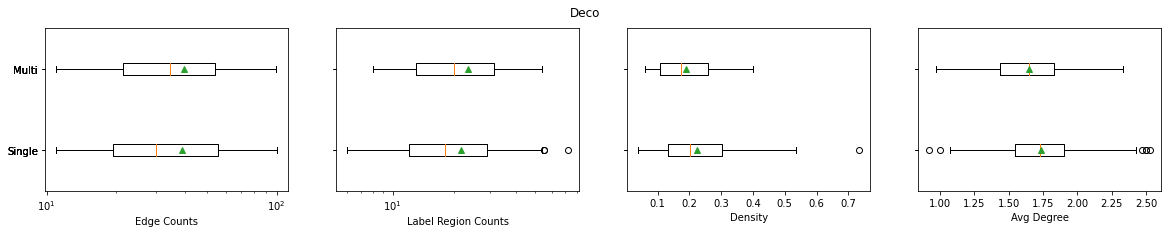

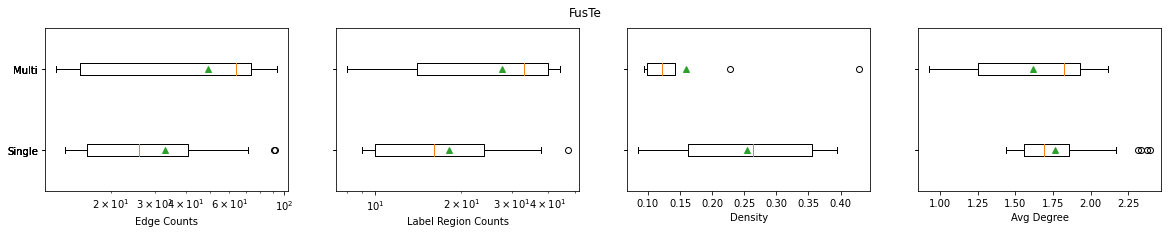

In [3]:
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (20,3)

for dataset in DATASETS:
    
    single_label_region_counts = []
    single_edge_counts = []
    single_densities = []
    single_avg_degree = []
    
    multi_label_region_counts = []
    multi_edge_counts = []
    multi_densities = []
    multi_avg_degree = []
    
    for file_key, data in refined_data[dataset].items():
        table_count = data["table_count"]
        label_region_count = data["label_region_count"]
        edge_count = data["edge_count"]
        
        if 10 < edge_count <= 100:
            if table_count == 1:
                single_label_region_counts.append(label_region_count)
                single_edge_counts.append(edge_count)
                single_densities.append((2 * edge_count) / (label_region_count * (label_region_count - 1)))
                single_avg_degree.append(edge_count / label_region_count)
            else:
                multi_label_region_counts.append(label_region_count)
                multi_edge_counts.append(edge_count)
                multi_densities.append((2 * edge_count) / (label_region_count * (label_region_count - 1)))
                multi_avg_degree.append(edge_count / label_region_count)
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.scatter(single_edge_counts, [1 for _ in range(len(single_edge_counts))], alpha=0.5, label="Single")
    ax1.scatter(multi_edge_counts, [2 for _ in range(len(multi_edge_counts))], alpha=0.5, label="Multi")
    ax1.set_xlabel("Edge Counts")
    ax1.legend()
    
    ax2.scatter(single_label_region_counts, [1 for _ in range(len(single_label_region_counts))], alpha=0.5, label="Single")
    ax2.scatter(multi_label_region_counts, [2 for _ in range(len(multi_label_region_counts))], alpha=0.5, label="Multi")
    ax2.set_xlabel("Label Region Counts")
    ax2.legend()
    
    ax3.scatter(single_densities, [1 for _ in range(len(single_densities))], alpha=0.5, label="Single")
    ax3.scatter(multi_densities, [2 for _ in range(len(multi_densities))], alpha=0.5, label="Multi")
    ax3.set_xlabel("Density")
    ax3.legend()

    fig.suptitle(dataset)
    """ 
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
    ax1.boxplot([single_edge_counts, multi_edge_counts], labels=["Single", "Multi"], vert=False, showmeans=True)
    ax1.set_xlabel("Edge Counts")
    ax1.set_xscale("log")
    
    ax2.boxplot([single_label_region_counts, multi_label_region_counts], labels=["Single", "Multi"], vert=False, showmeans=True)
    ax2.set_xlabel("Label Region Counts")
    ax2.set_xscale("log")
    
    ax3.boxplot([single_densities, multi_densities], labels=["Single", "Multi"], vert=False, showmeans=True)
    ax3.set_xlabel("Density")
    fig.suptitle(dataset)
    
    
    ax4.boxplot([single_avg_degree, multi_avg_degree], labels=["Single", "Multi"], vert=False, showmeans=True)
    ax4.set_xlabel("Avg Degree")
    fig.suptitle(dataset)

For files with an edge count between 10 and 101 we see no clear path. Fuste files seem easily identifyable, as the density of multitable files is vastly lower than the density of single table files.
However, this is not true for the deco dataset.

While avg. node degree would allow some certainty on whether a file is a multi table file, it is not sufficient.

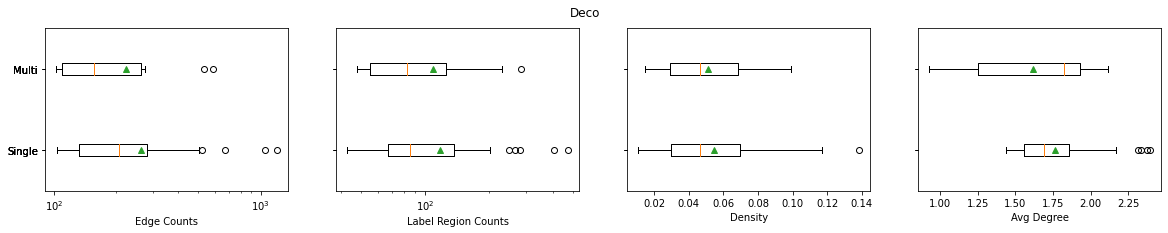

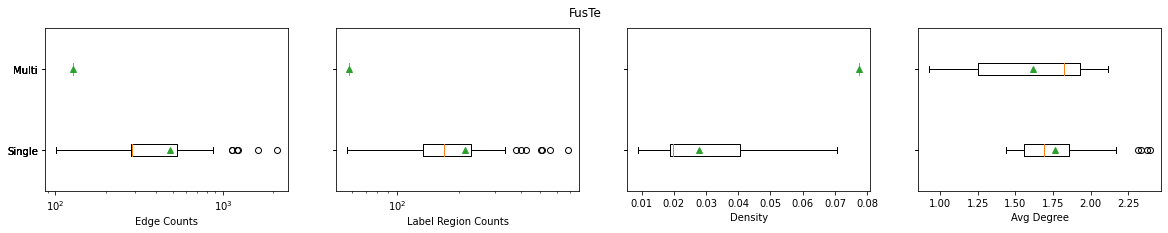

In [4]:
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (20, 3)

for dataset in DATASETS:
    
    single_label_region_counts = []
    single_edge_counts = []
    single_densities = []
    
    multi_label_region_counts = []
    multi_edge_counts = []
    multi_densities = []
    
    for file_key, data in refined_data[dataset].items():
        table_count = data["table_count"]
        label_region_count = data["label_region_count"]
        edge_count = data["edge_count"]
        
        if 100 < edge_count:
            if table_count == 1:
                single_label_region_counts.append(label_region_count)
                single_edge_counts.append(edge_count)
                single_densities.append((2 * edge_count) / (label_region_count * (label_region_count - 1)))
            else:
                multi_label_region_counts.append(label_region_count)
                multi_edge_counts.append(edge_count)
                multi_densities.append((2 * edge_count) / (label_region_count * (label_region_count - 1)))
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.scatter(single_edge_counts, [1 for _ in range(len(single_edge_counts))], alpha=0.5, label="Single")
    ax1.scatter(multi_edge_counts, [2 for _ in range(len(multi_edge_counts))], alpha=0.5, label="Multi")
    ax1.set_xlabel("Edge Counts")
    ax1.legend()
    
    ax2.scatter(single_label_region_counts, [1 for _ in range(len(single_label_region_counts))], alpha=0.5, label="Single")
    ax2.scatter(multi_label_region_counts, [2 for _ in range(len(multi_label_region_counts))], alpha=0.5, label="Multi")
    ax2.set_xlabel("Label Region Counts")
    ax2.legend()
    
    ax3.scatter(single_densities, [1 for _ in range(len(single_densities))], alpha=0.5, label="Single")
    ax3.scatter(multi_densities, [2 for _ in range(len(multi_densities))], alpha=0.5, label="Multi")
    ax3.set_xlabel("Density")
    ax3.legend()

    fig.suptitle(dataset)
    """ 
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
    ax1.boxplot([single_edge_counts, multi_edge_counts], labels=["Single", "Multi"], vert=False, showmeans=True)
    ax1.set_xlabel("Edge Counts")
    ax1.set_xscale("log")
    
    ax2.boxplot([single_label_region_counts, multi_label_region_counts], labels=["Single", "Multi"], vert=False, showmeans=True)
    ax2.set_xlabel("Label Region Counts")
    ax2.set_xscale("log")
    
    ax3.boxplot([single_densities, multi_densities], labels=["Single", "Multi"], vert=False, showmeans=True)
    ax3.set_xlabel("Density")
    fig.suptitle(dataset)    
    
    ax4.boxplot([single_avg_degree, multi_avg_degree], labels=["Single", "Multi"], vert=False, showmeans=True)
    ax4.set_xlabel("Avg Degree")
    fig.suptitle(dataset)

For files with an edge count above 100 we see no clear path. Fuste files is even more identifyable, as the density of multitable files is vastly lower than the density of single table files.
However, this is not true for the deco dataset.

The average node degree seems to be a good identifier for mutlitables, as single tables have no avg. degree not far below the mean of the avg. node degree.
This result is also valid for files with a lower edge count, but only not as clearly.

## Conclusion
Unfortunately, we can not derive an identifier just from the edge and node counts, except for a weak multi table identifier baes on the avg. node degree.

# Investigating Header Data Nodes
From the annotation data we know which of our nodes are labled as header or as data. We can investigate their proportions.

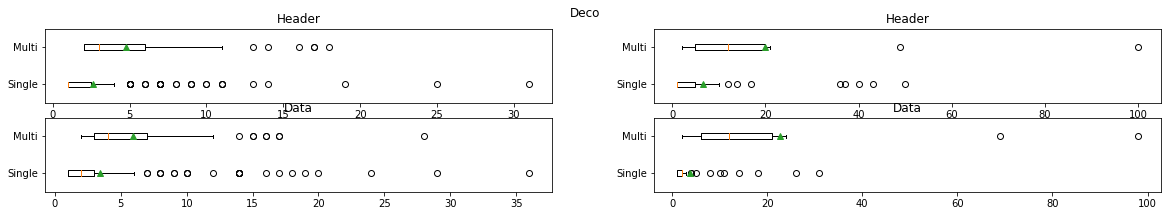

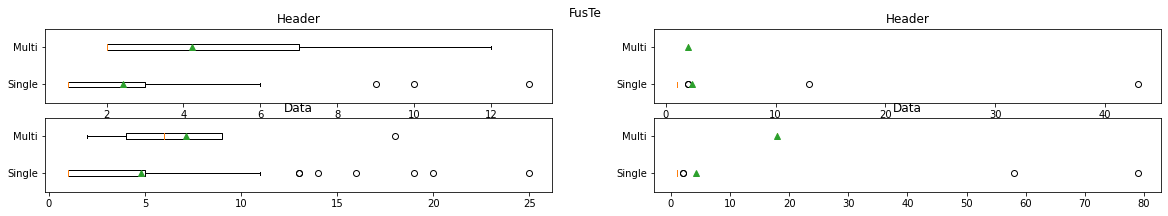

In [5]:


multi = lambda fd: fd[2] > 1
single = lambda fd: fd[2] == 1

for dataset in DATASETS:
    file_data = []
    for key, ref_data in refined_data[dataset].items():
        preproc_data = preprocessed_annotation_data[dataset][key]
        header_lrs = [
            element
            for region in preproc_data["regions"]
            for element in region["elements"]
            if element["type"] == "Header"
        ]
        data_lrs = [
            element
            for region in preproc_data["regions"]
            for element in region["elements"]
            if element["type"] == "Data"
        ]
        file_data.append((len(header_lrs), len(data_lrs), ref_data["table_count"], ref_data["edge_count"]))     
    
    b_10_100 = list(filter(lambda fd: 10 < fd[3] <= 100, file_data))
    a_100 = list(filter(lambda fd: 100 < fd[3], file_data))
    fig, axes = plt.subplots(2, 2)
    for i, lr_type in enumerate(["Header", "Data"]):
        for j, edge_counts in enumerate([b_10_100, a_100]):
                axes[i][j].boxplot(
                    [
                        list(map(lambda x: x[i], filter(single, edge_counts))),
                        list(map(lambda x: x[i], filter(multi, edge_counts))),
                    ],
                    vert=False,
                    labels=["Single", "Multi"],
                    showmeans=True,
                )
                axes[i][j].set_title(lr_type)
    fig.suptitle(dataset)

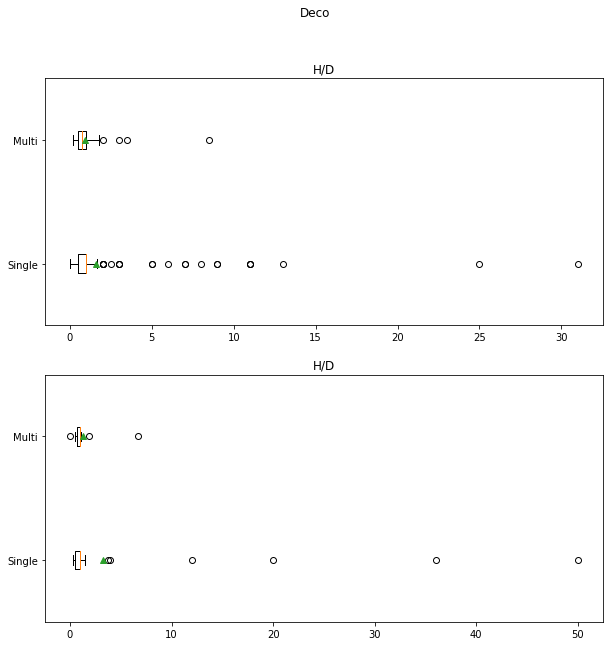

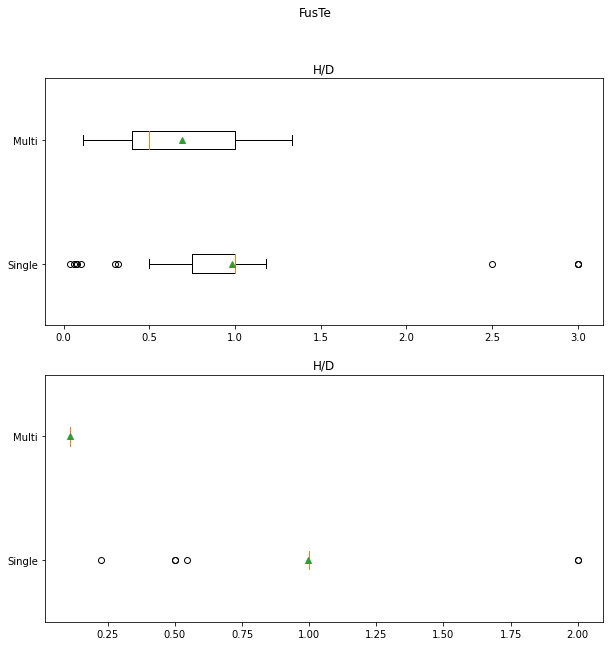

In [9]:


multi = lambda fd: fd[2] > 1
single = lambda fd: fd[2] == 1

for dataset in DATASETS:
    file_data = []
    for key, ref_data in refined_data[dataset].items():
        preproc_data = preprocessed_annotation_data[dataset][key]
        header_lrs = [
            element
            for region in preproc_data["regions"]
            for element in region["elements"]
            if element["type"] == "Header"
        ]
        data_lrs = [
            element
            for region in preproc_data["regions"]
            for element in region["elements"]
            if element["type"] == "Data"
        ]
        file_data.append((len(header_lrs), len(data_lrs), ref_data["table_count"], ref_data["edge_count"]))     
    
    b_10_100 = list(filter(lambda fd: 10 < fd[3] <= 100, file_data))
    a_100 = list(filter(lambda fd: 100 < fd[3], file_data))
    fig, axes = plt.subplots(2, figsize=(10, 10))
    for j, edge_counts in enumerate([b_10_100, a_100]):
            axes[j].boxplot(
                [
                    list(map(lambda x: x[0] / x[1], filter(single, edge_counts))),
                    list(map(lambda x: x[0] / x[1], filter(multi, edge_counts))),
                ],
                vert=False,
                labels=["Single", "Multi"],
                showmeans=True,
            )
            axes[j].set_title("H/D")
    fig.suptitle(dataset)

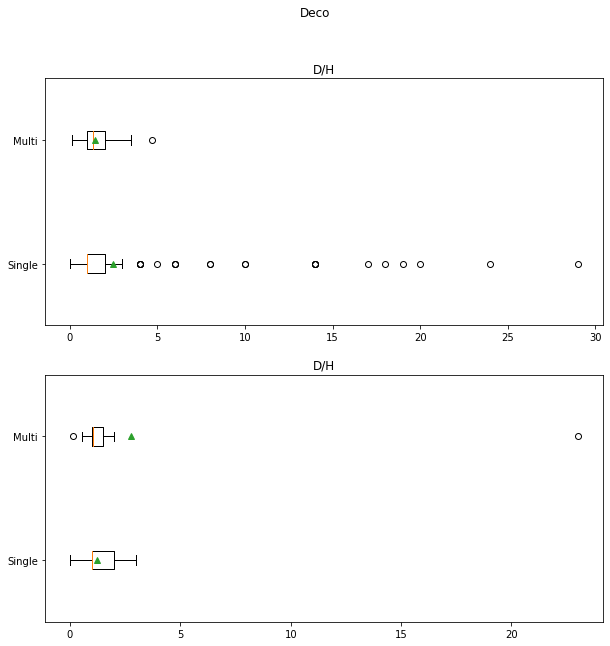

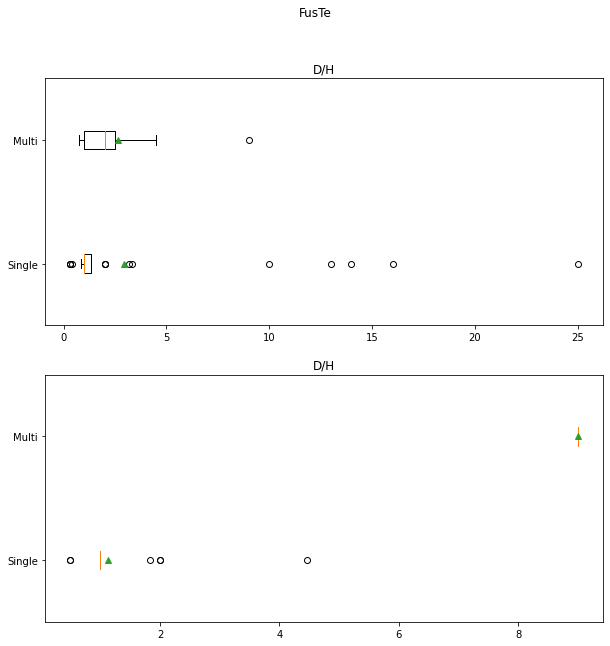

In [10]:


multi = lambda fd: fd[2] > 1
single = lambda fd: fd[2] == 1

for dataset in DATASETS:
    file_data = []
    for key, ref_data in refined_data[dataset].items():
        preproc_data = preprocessed_annotation_data[dataset][key]
        header_lrs = [
            element
            for region in preproc_data["regions"]
            for element in region["elements"]
            if element["type"] == "Header"
        ]
        data_lrs = [
            element
            for region in preproc_data["regions"]
            for element in region["elements"]
            if element["type"] == "Data"
        ]
        file_data.append((len(header_lrs), len(data_lrs), ref_data["table_count"], ref_data["edge_count"]))     
    
    b_10_100 = list(filter(lambda fd: 10 < fd[3] <= 100, file_data))
    a_100 = list(filter(lambda fd: 100 < fd[3], file_data))
    
    fig, axes = plt.subplots(2, figsize=(10, 10))
    for j, edge_counts in enumerate([b_10_100, a_100]):
            axes[j].boxplot(
                [
                    list(map(lambda x: x[1] / x[0], filter(single, edge_counts))),
                    list(map(lambda x: x[1] / x[0], filter(multi, edge_counts))),
                ],
                vert=False,
                labels=["Single", "Multi"],
                showmeans=True,
            )
            axes[j].set_title("D/H")
    fig.suptitle(dataset)

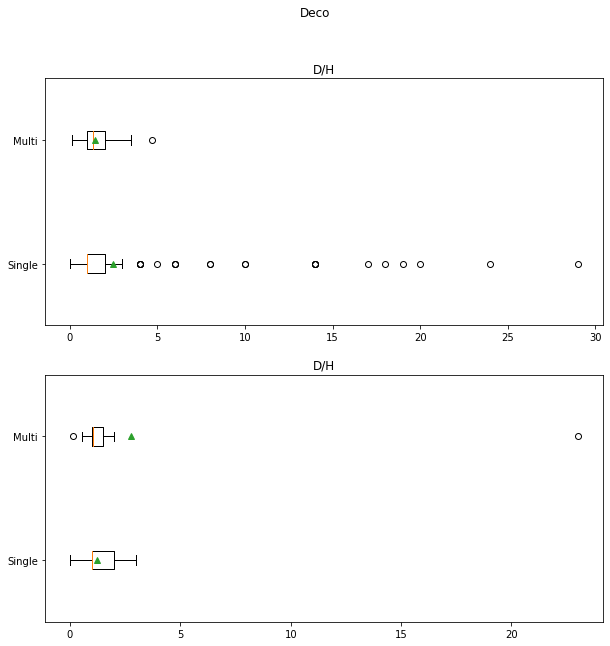

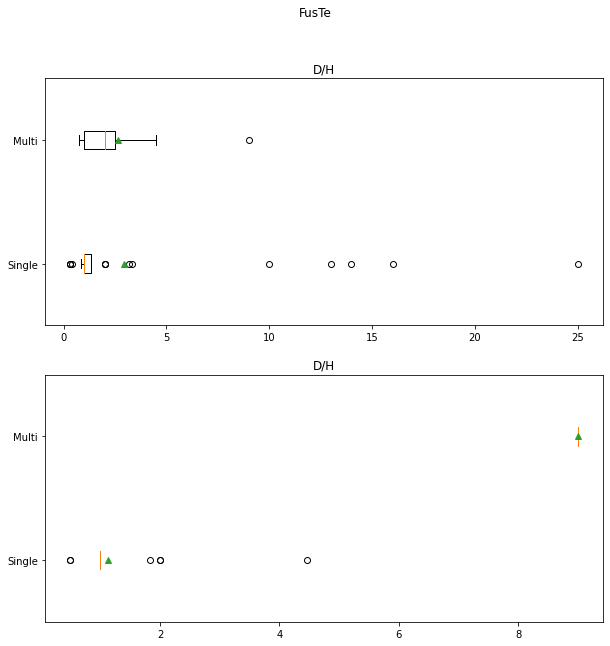

In [11]:


multi = lambda fd: fd[2] > 1
single = lambda fd: fd[2] == 1

for dataset in DATASETS:
    file_data = []
    for key, ref_data in refined_data[dataset].items():
        preproc_data = preprocessed_annotation_data[dataset][key]
        header_lrs = [
            element
            for region in preproc_data["regions"]
            for element in region["elements"]
            if element["type"] == "Header"
        ]
        data_lrs = [
            element
            for region in preproc_data["regions"]
            for element in region["elements"]
            if element["type"] == "Data"
        ]
        file_data.append((len(header_lrs), len(data_lrs), ref_data["table_count"], ref_data["edge_count"]))     
    
    b_10_100 = list(filter(lambda fd: 10 < fd[3] <= 100, file_data))
    a_100 = list(filter(lambda fd: 100 < fd[3], file_data))
    
    fig, axes = plt.subplots(2, figsize=(10, 10))
    for j, edge_counts in enumerate([b_10_100, a_100]):
            axes[j].boxplot(
                [
                    list(map(lambda x: x[1] / x[0], filter(single, edge_counts))),
                    list(map(lambda x: x[1] / x[0], filter(multi, edge_counts))),
                ],
                vert=False,
                labels=["Single", "Multi"],
                showmeans=True,
            )
            axes[j].set_title("D/H")
    fig.suptitle(dataset)